
# Trabajo Práctico Final
## Laboratorio de Datos
Martin Amster, Juan Alvarez Colombo y Nicolas Ledesma Cueli. 

2 de Diciembre de 2022

## Introducción

En este trabajo practico vamos a utilizar datasets sobre todos los partidos internacionales de selecciones de futbol masculino desde 1993 hasta el día de hoy y sus respectivos rankings FIFA

Vamos a cargar las librerias y los datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import plotly as px
px.io.renderers.default = "notebook_connected"

resultados = pd.read_csv("results.csv")

In [2]:
resultados['date'] = pd.to_datetime(resultados['date'], format='%Y-%m-%d')

resultados = resultados[resultados['date'].dt.year >= 1993]

Filtramos solo los resultados posteriores a 1993 en los que están involucrados los 140 países que tienen más partidos jugados

In [3]:
paises_participan = ["Qatar", "Ecuador", "Senegal", "Netherlands", "England", "Iran", "United States", "Wales", "Argentina", 
                     "Saudi Arabia", "Mexico", "Poland", "France", "Australia", "Denmark", "Tunisia", "Spain", "Costa Rica", 
                     "Germany", "Japan", "Belgium", "Canada", "Morocco", "Croatia", "Brazil", "Serbia", "Switzerland", 
                     "Cameroon", "Portugal", "Ghana", "Uruguay", "South Korea"]

resultados = resultados[resultados['tournament'] != "Friendly"]

paises = resultados['home_team'].value_counts().reset_index()
paises.columns = ['country', 'count']

paises = paises.sort_values(by='count', ascending=False).head(140)

resultados = resultados[resultados['home_team'].isin(paises['country']) & resultados['away_team'].isin(paises['country'])]

print(resultados.head(10))

            date     home_team    away_team  home_score  away_score  \
17705 1993-01-10        Angola     Zimbabwe         1.0         1.0   
17707 1993-01-10      DR Congo     Cameroon         1.0         2.0   
17708 1993-01-10       Senegal      Algeria         1.0         2.0   
17711 1993-01-16  South Africa      Nigeria         0.0         0.0   
17712 1993-01-16      Tanzania       Zambia         1.0         3.0   
17714 1993-01-17      Botswana  Ivory Coast         0.0         0.0   
17715 1993-01-17       Burundi      Algeria         0.0         0.0   
17716 1993-01-17      Ethiopia      Morocco         0.0         1.0   
17717 1993-01-17    Mozambique        Gabon         1.0         1.0   
17718 1993-01-17       Namibia   Madagascar         0.0         1.0   

                                 tournament          city       country  \
17705          FIFA World Cup qualification        Luanda        Angola   
17707          FIFA World Cup qualification      Kinshasa         Za

Luego sumamos el dataframe con rankings desde 1993 y le agregamos el ranking como otra columna en resultados

In [4]:
ranking = pd.read_csv("ranking_fifa.csv")

ranking = ranking.replace({"USA": "United States", "Korea Republic": "South Korea", "IR Iran": "Iran"}, regex=True)

ranking['rank_date'] = pd.to_datetime(ranking['rank_date'], format='%Y-%m-%d')

ranking['rank'] = ranking['rank'].astype(int)

print(ranking.head(10))

   rank                    country_full country_abrv  total_points  \
0     1                         Germany          GER          57.0   
1    96                           Syria          SYR          11.0   
2    97                    Burkina Faso          BFA          11.0   
3    99                          Latvia          LVA          10.0   
4   100                         Burundi          BDI          10.0   
5   101                            Togo          TOG          10.0   
6   102                          Angola          ANG          10.0   
7    95                        Suriname          SUR          12.0   
8   103                      Luxembourg          LUX          10.0   
9   105  St. Vincent and the Grenadines          VIN           9.0   

   previous_points  rank_change confederation  rank_date  
0              0.0            0          UEFA 1992-12-31  
1              0.0            0           AFC 1992-12-31  
2              0.0            0           CAF 1992-1

Para ponerlo como columna el ranking, tomamos el primer ranking del año en el que se jugó el partido

In [5]:
resultados['anio'] = resultados['date'].dt.year.astype(int)

ranking['anio'] = ranking['rank_date'].dt.year.astype(int)

resultados['rank_home'] = None
for i, row in resultados.iterrows():
    home_team = row['home_team']
    anio = row['anio']
    mask = (ranking['country_full'] == home_team) & (ranking['anio'] == anio)
    rank = ranking.loc[mask, 'rank'].values
    if len(rank) > 0:
        resultados.at[i, 'rank_home'] = rank[0]

resultados['rank_away'] = None
for i, row in resultados.iterrows():
    away_team = row['away_team']
    anio = row['anio']
    mask = (ranking['country_full'] == away_team) & (ranking['anio'] == anio)
    rank = ranking.loc[mask, 'rank'].values
    if len(rank) > 0:
        resultados.at[i, 'rank_away'] = rank[0]

## Analisis exploratorio de los datos
## 1.

Primero vamos a ver cuáles son los resultados más repetidos

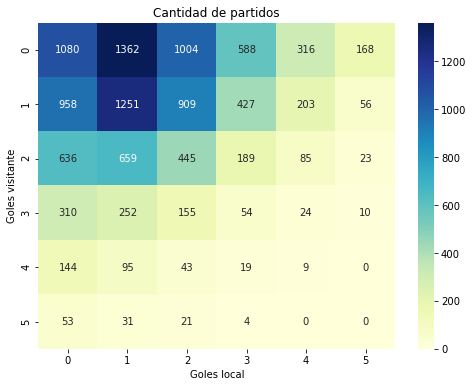

In [6]:
densidad_resultados = np.zeros((36, 3))
colnames = ["Goles_local", "Goles_visitante", "Cant_apariciones"]

x = np.repeat(np.arange(6), 6)
y = np.tile(np.arange(6), 6)

densidad_resultados = pd.DataFrame(densidad_resultados, columns=colnames)
densidad_resultados["Goles_local"] = x
densidad_resultados["Goles_visitante"] = y

for i in range(36):
    densidad_resultados.at[i, "Cant_apariciones"] = len(resultados[(densidad_resultados["Goles_local"].iloc[i] == resultados["home_score"]) & (densidad_resultados["Goles_visitante"].iloc[i] == resultados["away_score"])])

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(densidad_resultados.pivot("Goles_visitante", "Goles_local", "Cant_apariciones"), annot=True, fmt=".0f", cmap="YlGnBu")
heatmap.set_xlabel("Goles local")
heatmap.set_ylabel("Goles visitante")
plt.title("Cantidad de partidos")
plt.show()


Los resultados más comunes son 1-0 y 1-1 y a medida que hay una mayor cantidad de goles hay menos partidos con esos resultados. Estos resultados son los esperados.

Agregamos una columna con la diferencia entre goles del local y del visitante y añadimos una columna que dice quien ganó o si hubo empate

In [7]:
resultados['dif_goles'] = resultados['home_score'] - resultados['away_score']

resultados['ganador'] = None

resultados.loc[resultados['dif_goles'] > 0, 'ganador'] = resultados.loc[resultados['dif_goles'] > 0, 'home_team']
resultados.loc[resultados['dif_goles'] == 0, 'ganador'] = "Empate"
resultados.loc[resultados['dif_goles'] < 0, 'ganador'] = resultados.loc[resultados['dif_goles'] < 0, 'away_team']

Con esta nueva columna vamos a ver cuáles son los 10 equipos que más partidos oficiales ganaron

In [8]:
ganador_frecuencia = resultados.loc[resultados['tournament'] != "Friendly", 'ganador'].value_counts()

top_ganadores = ganador_frecuencia.sort_values(ascending=False).iloc[1:11]

print(top_ganadores)

Brazil           164
Mexico           162
Spain            159
Germany          153
Japan            142
Italy            139
United States    139
Netherlands      137
Portugal         136
France           131
Name: ganador, dtype: int64


## 2.

Ahora vemos que tal le fue a cada selección campeona (desde 1993) previo al mundial que ganó

In [9]:
campeones = np.zeros((6, 3))
campeones_names = ["France", "Brazil", "Italy", "Spain", "Germany", "France"] 

campeones_index = ["Francia1998", "Brasil", "Italia", "Espana", "Alemania", "Francia2018"]
colnames = ["Victorias", "Empates", "Derrotas"]

anio_inicial = 1994
for i in range(6):
    victorias = 0
    empates = 0
    derrotas = 0
    for j in range(anio_inicial + 1, anio_inicial + 4):
        victorias += len(resultados[(resultados['ganador'] == campeones_names[i]) & (resultados['anio'] == j)])
        empates += len(resultados[(resultados['ganador'] == "Empate") & (resultados['anio'] == j) & ((resultados['home_team'] == campeones_names[i]) | (resultados['away_team'] == campeones_names[i]))])
        derrotas += len(resultados[(resultados['ganador'] != campeones_names[i]) & (resultados['ganador'] != "Empate") & (resultados['anio'] == j) & ((resultados['home_team'] == campeones_names[i]) | (resultados['away_team'] == campeones_names[i]))])
    campeones[i, 0] = victorias
    campeones[i, 1] = empates
    campeones[i, 2] = derrotas
    anio_inicial += 4

campeones_index = ["Francia1998", "Brasil", "Italia", "Espana", "Alemania", "Francia2018"]

campeones_df = pd.DataFrame(campeones, index=campeones_index, columns=colnames)

print(campeones_df)

             Victorias  Empates  Derrotas
Francia1998        6.0      7.0       1.0
Brasil            22.0      5.0      11.0
Italia            12.0      5.0       1.0
Espana            26.0      2.0       1.0
Alemania          19.0      1.0       1.0
Francia2018       12.0      3.0       2.0


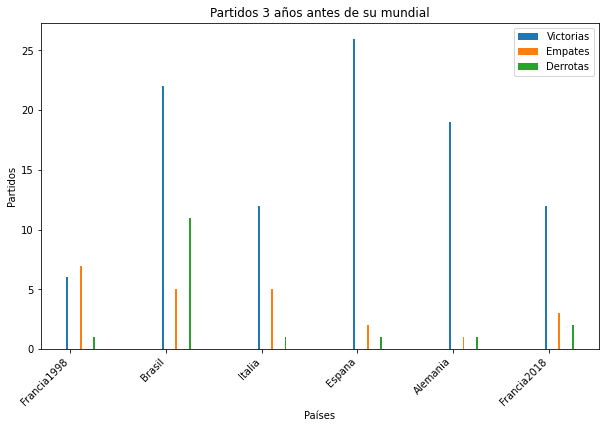

In [10]:
colors = {'Victorias': '#1f77b4', 'Empates': '#ff7f0e', 'Derrotas': '#2ca02c'}

fig, ax = plt.subplots(figsize=(10, 6)) 
width = 0.02  
countries = campeones_df.index

for i, category in enumerate(campeones_df.columns):
    x = np.arange(len(countries)) + i * (len(countries) + 1) * width  
    ax.bar(x, campeones_df[category], width=width, color=colors[category], label=category)

ax.set_xticks(np.arange(len(countries)) + 1.5 * width)
ax.set_xticklabels(countries, rotation=45, ha='right') 
ax.set_ylabel("Partidos")
ax.set_xlabel("Países")
ax.set_title("Partidos 3 años antes de su mundial")
ax.legend()

plt.show()

Y ahora veremos cómo les fue a las selecciones candidatas de Qatar 2022 en los últimos 3 años

In [11]:
candidatos = np.zeros((6, 3))
candidatos_names = ["France", "Brazil", "Argentina", "England", "Belgium", "Spain"]

candidatos_index = ["Francia", "Brasil", "Argentina", "Inglaterra", "Belgica", "España"]
colnames = ["Victorias", "Empates", "Derrotas"]

anio_inicial = 2018

for i in range(6):
    victorias = 0
    empates = 0
    derrotas = 0
    for j in range(anio_inicial + 1, anio_inicial + 4):
        victorias += len(resultados[(resultados['ganador'] == candidatos_names[i]) & (resultados['anio'] == j)])
        empates += len(resultados[(resultados['ganador'] == "Empate") & (resultados['anio'] == j) & ((resultados['home_team'] == candidatos_names[i]) | (resultados['away_team'] == candidatos_names[i]))])
        derrotas += len(resultados[(resultados['ganador'] != candidatos_names[i]) & (resultados['ganador'] != 'Empate') & (resultados['anio'] == j) & ((resultados['home_team'] == candidatos_names[i]) | (resultados['away_team'] == candidatos_names[i]))])
    candidatos[i, 0] = victorias
    candidatos[i, 1] = empates
    candidatos[i, 2] = derrotas

candidatos_index = ["Francia", "Brasil", "Argentina", "Inglaterra", "Belgica", "España"]

candidatos_df = pd.DataFrame(candidatos, index=candidatos_index, columns=colnames)

print(candidatos_df)


            Victorias  Empates  Derrotas
Francia          21.0      8.0       1.0
Brasil           20.0      5.0       2.0
Argentina        17.0      8.0       2.0
Inglaterra       19.0      6.0       4.0
Belgica          25.0      2.0       4.0
España           18.0      9.0       3.0


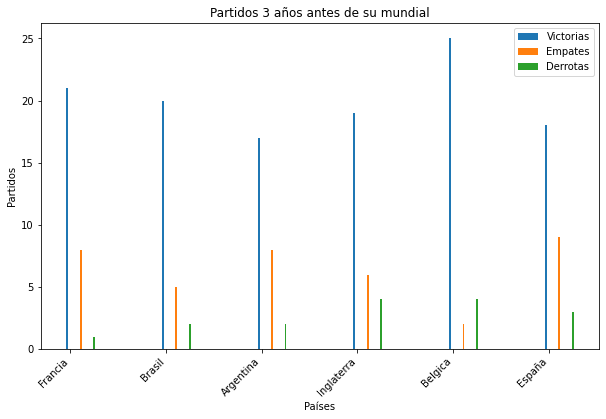

In [12]:
colors = {'Victorias': '#1f77b4', 'Empates': '#ff7f0e', 'Derrotas': '#2ca02c'}

fig, ax = plt.subplots(figsize=(10, 6)) 
width = 0.02  
countries = candidatos_df.index

for i, category in enumerate(candidatos_df.columns):
    x = np.arange(len(countries)) + i * (len(countries) + 1) * width 
    ax.bar(x, candidatos_df[category], width=width, color=colors[category], label=category)

ax.set_xticks(np.arange(len(countries)) + 1.5 * width)
ax.set_xticklabels(countries, rotation=45, ha='right') 
ax.set_ylabel("Partidos")
ax.set_xlabel("Países")
ax.set_title("Partidos 3 años antes de su mundial")
ax.legend()

plt.show()

Para comparar estos dos gráficos podemos tomar cantidad de puntos por partido de estos equipos durante esos años (3 por victoria, 1 por empate)

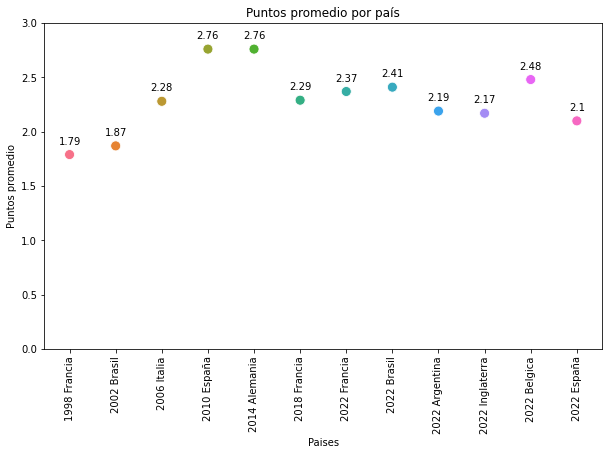

In [13]:
campeones_df['puntos_promedio'] = round((3 * campeones_df['Victorias'] + campeones_df['Empates']) / 
                                      (campeones_df['Victorias'] + campeones_df['Empates'] + campeones_df['Derrotas']), 2)
candidatos_df['puntos_promedio'] = round((3 * candidatos_df['Victorias'] + candidatos_df['Empates']) / 
                                       (candidatos_df['Victorias'] + candidatos_df['Empates'] + candidatos_df['Derrotas']), 2)

campeones_df.index = ["1998 Francia", "2002 Brasil", "2006 Italia", "2010 España", "2014 Alemania", "2018 Francia"]
candidatos_df.index = ["2022 Francia", "2022 Brasil", "2022 Argentina", "2022 Inglaterra", "2022 Belgica", "2022 España"]

campeones_df['paises'] = campeones_df.index
candidatos_df['paises'] = candidatos_df.index

mergeados = pd.concat([campeones_df, candidatos_df])

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=mergeados, x='paises', y='puntos_promedio', hue='paises', s=100, legend=False)
plt.ylim(0, 3)

for index, row in mergeados.iterrows():
    scatter.annotate(row['puntos_promedio'], (row['paises'], row['puntos_promedio']), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(rotation=90)
plt.xlabel('Paises')
plt.ylabel('Puntos promedio')
plt.title('Puntos promedio por país')
plt.show()


Con este gráfico se puede observar que todas las selecciones campeonas tienen promedio de puntos por partido entre 1.79 y 2.76 los tres años anteriores a salir campeón. Todos los candidatos de este año tienen valores en ese rango también. Ninguna selección actual llega al nivel superlativo de España y Alemania antes del mundial 2010 y 2014, respectivamente, ni al piso de Francia antes de 1998.

## 3.

Para ver un poco el dataset de ranking fifa vamos a ver cómo evolucionó el ranking de los candidatos desde 1993, recordando que si el número del ranking es mayor, significa que el país está peor futbolísticamente.

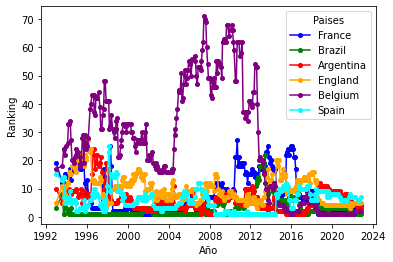

In [14]:
vec_cand = ["France", "Brazil", "Argentina", "England", "Belgium", "Spain"]

color_map = {"France": "blue", "Brazil": "green", "Argentina": "red", 
             "England": "orange", "Belgium": "purple", "Spain": "cyan"}

rank_candidatos = ranking[ranking['country_full'].isin(vec_cand)]

for country in vec_cand:
    country_data = rank_candidatos[rank_candidatos['country_full'] == country]
    plt.plot(country_data['rank_date'], country_data['rank'], marker='o', linestyle='-', markersize=4, color=color_map[country], label=country)

plt.xlabel('Año')
plt.ylabel('Ranking')
plt.legend(title='Paises')

plt.show()

Belgica ganó mucho ranking los últimos años, las otras selecciones siempre fueron potencias del fútbol.

## 4.

Nuestro objetivo ahora es ver que influencia tiene jugar de local comparado con jugar un partido en un pais neutral

In [15]:
vic_loc = []
der_loc = []
emp_loc = []
vic_neu = []
der_neu = []
emp_neu = []

for country in paises_participan:
    matches_home = resultados[resultados['country'] == country]
    matches_won_home = matches_home[matches_home['ganador'] == country]
    matches_draw_home = matches_home[(matches_home['ganador'] == "Empate") & (matches_home['home_team'] == country)]
    matches_lost_home = matches_home[(matches_home['ganador'] != country) & (matches_home['ganador'] != "Empate") & (matches_home['home_team'] == country)]
    
    vic_loc.append(len(matches_won_home) / len(matches_home))
    der_loc.append(len(matches_lost_home) / len(matches_home))
    emp_loc.append(len(matches_draw_home) / len(matches_home))
    
    matches_neutral = resultados[(resultados['home_team'] == country) | (resultados['away_team'] == country) & (resultados['neutral'] == True)]
    matches_won_neutral = matches_neutral[matches_neutral['ganador'] == country]
    matches_draw_neutral = matches_neutral[(matches_neutral['ganador'] == "Empate")]
    matches_lost_neutral = matches_neutral[(matches_neutral['ganador'] != "Empate") & (matches_neutral['ganador'] != country)]
    
    vic_neu.append(len(matches_won_neutral) / len(matches_neutral))
    der_neu.append(len(matches_lost_neutral) / len(matches_neutral))
    emp_neu.append(len(matches_draw_neutral) / len(matches_neutral))

matriz_local = pd.DataFrame({"Victorias": vic_loc, "Empates": emp_loc, "Derrotas": der_loc}, index=paises_participan)
matriz_neutral = pd.DataFrame({"Victorias": vic_neu, "Empates": emp_neu, "Derrotas": der_neu}, index=paises_participan)

Hacemos el ternary plot para ver como es la distribución tanto en partidos de local como neutrales

In [21]:
from plotly.express import scatter_ternary

In [22]:
fig = scatter_ternary(matriz_local, a="Victorias", b="Empates", c="Derrotas")
fig.update_layout({
    'ternary': {},
    'annotations': [{
      'text': 'De local',
        'x': 0.7,
        'y': 0.8,
        'font': { 'size': 40 }
    }]
})
fig.show()
fig2 = scatter_ternary(matriz_neutral, a="Victorias", b="Empates", c="Derrotas")
fig2.update_layout({
    'ternary': {},
    'annotations': [{
      'text': 'Neutral',
        'x': 0.7,
        'y': 0.8,
        'font': { 'size': 40 }
    }]
})
fig2.show()

Se puede observar en el ternary plot de los partidos como local tienen mucha más probabilidad de ganar que los neutrales ya que todos los puntos tienen una tendencia a estar más cerca de la punta de victorias que en los partidos como neutral.

Como vamos a hacer un analisis de los mundiales, los partidos van a ser en su gran mayoría neutrales, salvo para el país organizador del mundial.

# Modelado de datos

In [23]:
resultados = resultados.dropna()

Hacemos una función llamada partidos_anteriores que le de un peso a como salieron los partidos anteriores entre dos equipos. Esto va a ayudar a predecir partidos actuales

In [24]:
def partidos_anteriores(pais1, pais2, resultados, m):
    partidos_entre_ellos = resultados[((resultados['home_team'] == pais1) | (resultados['away_team'] == pais1)) &
                                      ((resultados['home_team'] == pais2) | (resultados['away_team'] == pais2))]
    
    partidos_entre_ellos = partidos_entre_ellos.tail(3)
    
    if len(partidos_entre_ellos) == 3:
        pais1_wins = len(partidos_entre_ellos[partidos_entre_ellos['ganador'] == pais1])
        pais2_wins = len(partidos_entre_ellos[partidos_entre_ellos['ganador'] == pais2])
        
        if pais1_wins > pais2_wins:
            return m
        elif pais1_wins < pais2_wins:
            return -m
    
    return 0

Si en los últimos 3 partidos entre sí (si es que jugaron 3 partidos) uno de los dos equipos ganó más, va a recibir un extra para la predicción del partido

Agregamos goles por partido como variable porque al pensar distintos modelos naive nos dimos cuenta que es una variable que predice relativamente bien

In [25]:
def goles_pp(pais1, pais2, resultados, n, m):
    goles_1_home = resultados.loc[resultados['home_team'] == pais1, 'home_score'].sum()
    goles_1_away = resultados.loc[resultados['away_team'] == pais1, 'away_score'].sum()
    partidos_1 = len(resultados[(resultados['home_team'] == pais1) | (resultados['away_team'] == pais1)])
    goles_1 = (goles_1_home + goles_1_away) / partidos_1 if partidos_1 > 0 else 0
    
    goles_2_home = resultados.loc[resultados['home_team'] == pais2, 'home_score'].sum()
    goles_2_away = resultados.loc[resultados['away_team'] == pais2, 'away_score'].sum()
    partidos_2 = len(resultados[(resultados['home_team'] == pais2) | (resultados['away_team'] == pais2)])
    goles_2 = (goles_2_home + goles_2_away) / partidos_2 if partidos_2 > 0 else 0

    if abs(goles_1 - goles_2) < n:
        return 0
    elif goles_1 > goles_2:
        return m
    else:
        return -m

Hicimos una predicción del partido con una función llamada result, que toma tambien las dos funciones anteriores

In [26]:
def result(pais1, pais2, resultados, ranking, n, j, p, m):
    partido = pd.DataFrame(columns=["home_team", "away_team", "rank_home", "rank_away"])
    partido.loc[0] = [pais1, pais2, ranking.loc[ranking['country_full'] == pais1, 'rank'].iloc[-1],
                        ranking.loc[ranking['country_full'] == pais2, 'rank'].iloc[-1]]
    
    coeficientes = LinearRegression()
    X = resultados[resultados['home_team'] == pais1][['rank_home', 'rank_away']]
    y = resultados[resultados['home_team'] == pais1]['dif_goles']
    coeficientes.fit(X, y)
    prediccion = coeficientes.predict(partido[['rank_home', 'rank_away']])

    coeficientes = LinearRegression()
    X = resultados[resultados['away_team'] == pais1][['rank_home', 'rank_away']]
    y = resultados[resultados['away_team'] == pais1]['dif_goles']
    coeficientes.fit(X, y)
    prediccion = np.append(prediccion, -coeficientes.predict(partido[['rank_home', 'rank_away']]))

    coeficientes = LinearRegression()
    X = resultados[resultados['away_team'] == pais2][['rank_home', 'rank_away']]
    y = resultados[resultados['away_team'] == pais2]['dif_goles']
    coeficientes.fit(X, y)
    prediccion = np.append(prediccion, coeficientes.predict(partido[['rank_home', 'rank_away']]))

    coeficientes = LinearRegression()
    X = resultados[resultados['home_team'] == pais2][['rank_home', 'rank_away']]
    y = resultados[resultados['home_team'] == pais2]['dif_goles']
    coeficientes.fit(X, y)
    prediccion = np.append(prediccion, -coeficientes.predict(partido[['rank_home', 'rank_away']]))

    prob_1 = np.mean(prediccion) + partidos_anteriores(pais1, pais2, resultados, j) + goles_pp(pais1, pais2, resultados, p, m)
    if prob_1 < (-n):
        return pais2
    elif prob_1 > n:
        return pais1
    else:
        return "Empate"


¿Como se usa la función? Ejemplo:

In [27]:
print(result("Portugal", "Uruguay", resultados, ranking, n=0.15, j=0.4, p=0.2, m=0.1))

Portugal


Hacemos una función de cross validation

In [28]:
def crossval(resultados, muestras, n=0.15, j=None, p=None, m=None):
    test = int(0.2 * len(resultados))
    prop_correcta = []
    for _ in range(muestras):
        filas = np.random.choice(resultados.index, test, replace=False)
        df_pred = resultados.loc[filas].copy()
        df_pred['prediccion'] = None
        for i in range(len(df_pred)):
            df_pred.at[df_pred.index[i], 'prediccion'] = result(df_pred.at[df_pred.index[i], 'home_team'],
                                                                 df_pred.at[df_pred.index[i], 'away_team'],
                                                                 resultados.drop(filas), ranking, n, j, p, m)
        prop_correcta.append((df_pred['prediccion'] == df_pred['ganador']).mean())
    return np.mean(prop_correcta)

Hicimos cross validation para buscar el mejor n (numero que determina empates)

In [29]:
i = 0
while i < 0.2:
    print("Con n =", i, "es", crossval(resultados, 3, n=i, j=0.4, p=0.1, m=0.4))
    i += 0.04

Con n = 0 es 0.5526552655265528
Con n = 0.04 es 0.5498049804980498
Con n = 0.08 es 0.551005100510051
Con n = 0.12 es 0.5445544554455445
Con n = 0.16 es 0.538103810381038


Terminamos eligiendo 0.15 para que algunos partidos den empate a pesar de que no da el mejor valor de predicción al hacer cross validation. Nos dimos cuenta que el empate es el resultado más dificil de predecir y por ello nunca tiene la máxima probabilidad en los modelos (tanto en apuestas como modelos como 301060)

Vimos la precision de nuestro modelo con cross validation y buscamos las mejores variables para poner en las funciones de forma tal que la predicción sea lo mejor posible

In [30]:
j = 0.2
while j <= 0.5:
    print("Con j =", j, "es", crossval(resultados, 5, n=0.15, j=j, p=0.3, m=0.4))
    j += 0.1

Con j = 0.2 es 0.5398739873987399
Con j = 0.30000000000000004 es 0.5373537353735374
Con j = 0.4 es 0.5374437443744374
Con j = 0.5 es 0.54005400540054


In [31]:
p = 0.1
while p <= 0.4:
    print("Con p =", p, "es", crossval(resultados, 5, n=0.15, j=0.4, p=p, m=0.4))
    p += 0.1

Con p = 0.1 es 0.5429342934293429
Con p = 0.2 es 0.5456345634563456
Con p = 0.30000000000000004 es 0.5342934293429343
Con p = 0.4 es 0.5344734473447346


Con esto concluimos que aproximadamente los mejores valores para la función result son: j=0.4 (el peso que se le agrega por los últimos 3 partidos), p=0.2 (el valor usado en goles por partido para determinar empate) y m=0.4 (el peso que se le agrega por promedio de goles). Estos pueden variar en cada corrida del código pero si buscábamos el óptimo iterando entre todos los valores teníamos que hacer muchísimos mas cross validations, además que estaría bueno hacer más iteraciones.

Entonces hacemos un cross validation en el que no tomamos sample de test, sino que intentamos predecir los partidos más recientes

In [32]:
def crossval_reciente(resultados, ranking, n=0.15, j=None, p=None, m=None):
    prop_correcta = []
    num_recent_matches = 500
    
    start_index = max(len(resultados) - num_recent_matches, 0)
    end_index = len(resultados)
    
    df_pred = resultados.iloc[start_index:end_index].copy()
    df_pred['prediccion'] = None
    
    for i in range(len(df_pred)):
        pais1 = df_pred['home_team'].iloc[i]
        pais2 = df_pred['away_team'].iloc[i]
        df_pred['prediccion'].iloc[i] = result(pais1, pais2, resultados.drop(df_pred.index), ranking, n, j, p, m)
    
    prop_correcta = sum(df_pred['prediccion'] == df_pred['ganador']) / len(df_pred)
    return prop_correcta

In [33]:
import warnings

warnings.filterwarnings("ignore")

prop_correcta = crossval_reciente(resultados, ranking, n=0.15, j=0, p=0, m=0)

print("Con valores igual a cero para las vairables el resultado del cross validation es: ", prop_correcta)

prop_correcta_varaibles = crossval_reciente(resultados, ranking, n=0.15, j=0.4, p=0.1, m=0.4)

print("Con los valores buscados para las vairables el resultado del cross validation es: ", prop_correcta_varaibles)

Con valores igual a cero para las vairables el resultado del cross validation es:  0.45
Con los valores buscados para las vairables el resultado del cross validation es:  0.532


Si no tomáramos las variables extra la predicción sería bastante mala.

Sin embargo, cuando predecimos los resultados del mundial nos pasa al revés: predice mejor sin esas variables extra. Obviamente los partidos del mundial son muy pocos para hacer un buen test del algoritmo, además que hay factores en un mundial que no son posibles de determinar con datasets.

In [34]:
locales = ["Qatar", "England", "Senegal", "United States", "Argentina", "Denmark", "Mexico", "France", "Morocco", "Germany", "Spain", "Belgium", "Switzerland", "Uruguay", "Portugal", "Brazil", "Wales", "Qatar", "Netherlands", "England", "Tunisia", "Poland", "France", "Japan", "Belgium", "Croatia", "Spain", "Serbia", "South Korea", "Brazil", "Uruguay", "Croatia", "Canada", "Japan", "Costa Rica", "South Korea", "Ghana"]
visitantes = ["Ecuador", "Iran", "Netherlands", "Wales", "Saudi Arabia", "Tunisia", "Poland", "Australia", "Croatia", "Japan", "Costa Rica", "Canada", "Cameroon", "South Korea", "Ghana", "Serbia", "Iran", "Senegal", "Ecuador", "United States", "Australia", "Saudi Arabia", "Denmark", "Costa Rica", "Morocco", "Canada", "Germany", "Cameroon", "Ghana", "Switzerland", "Portugal", "Belgium", "Morocco", "Spain", "Germany", "Portugal", "Uruguay"]
resultado_real = ["Ecuador", "England", "Netherlands", "Empate", "Saudi Arabia", "Empate", "Empate", "France", "Empate", "Japan", "Spain", "Belgium", "Switzerland", "Empate", "Portugal", "Brazil", "Iran", "Senegal", "Empate", "Empate", "Australia", "Poland", "France", "Costa Rica", "Morocco", "Croatia", "Empate", "Empate", "Ghana", "Brazil", "Portugal", "Empate", "Morocco", "Japan", "Germany", "South Korea", "Uruguay"]

partidos_jugados = pd.DataFrame(columns=["local", "visitante", "resultado", "prediccion"])
partidos_jugados["local"] = locales
partidos_jugados["visitante"] = visitantes
partidos_jugados["resultado"] = resultado_real

for i in range(len(locales)):
    local = locales[i]
    visitante = visitantes[i]
    result_prediction = result(local, visitante, resultados, ranking, 0.15, 0.4, 0.2, 0.4)
    partidos_jugados.at[i, "prediccion"] = result_prediction

precision = np.mean(partidos_jugados["resultado"] == partidos_jugados["prediccion"])
print("Hasta ahora la precisión de nuestro modelo es", precision)


Hasta ahora la precisión de nuestro modelo es 0.40540540540540543


In [35]:
print(partidos_jugados)

            local      visitante     resultado     prediccion
0           Qatar        Ecuador       Ecuador        Ecuador
1         England           Iran       England        England
2         Senegal    Netherlands   Netherlands    Netherlands
3   United States          Wales        Empate  United States
4       Argentina   Saudi Arabia  Saudi Arabia      Argentina
5         Denmark        Tunisia        Empate        Denmark
6          Mexico         Poland        Empate         Mexico
7          France      Australia        France         France
8         Morocco        Croatia        Empate        Croatia
9         Germany          Japan         Japan        Germany
10          Spain     Costa Rica         Spain          Spain
11        Belgium         Canada       Belgium        Belgium
12    Switzerland       Cameroon   Switzerland    Switzerland
13        Uruguay    South Korea        Empate    South Korea
14       Portugal          Ghana      Portugal       Portugal
15      

Como nos dio mal vamos a generarnos las mejores variables mundial. Es decir, en lugar de usar las que usamos en cross validation, vamos a ver cuales son las variables óptimas para este mundial

In [36]:
partidos_jugados = pd.DataFrame(columns=["local", "visitante", "resultado", "prediccion"])
partidos_jugados["local"] = locales
partidos_jugados["visitante"] = visitantes
partidos_jugados["resultado"] = resultado_real

best_accuracy = 0
best_vars = [0, 0, 0, 0]

i = 0
while i < 0.25:
    j = 0
    while j < 0.6:
        k = 0
        while k < 0.35:
            l = 0
            while l < 0.6:
                for idx, row in partidos_jugados.iterrows():
                    partidos_jugados.at[idx, "prediccion"] = result(row["local"], row["visitante"], resultados, ranking, i, j, k, l)
                
                accuracy = np.mean(partidos_jugados["resultado"] == partidos_jugados["prediccion"])
                if accuracy > best_accuracy:
                    best_vars = [i, j, k, l]
                    best_accuracy = accuracy
                l += 0.1
            k += 0.05
        j += 0.1
    i += 0.05

print("La mejor predicción se hace con las variables", best_vars, "y es", best_accuracy)


La mejor predicción se hace con las variables [0.05, 0.30000000000000004, 0, 0.4] y es 0.5405405405405406


Y después podemos usar esas variables para predecir partidos siguientes

In [37]:
print(result("Brazil", "Switzerland", resultados, ranking, best_vars[0], best_vars[1], best_vars[2], best_vars[3]))

Brazil


Hacemos un método naive en el que gana el que tiene mayor proporción de victorias por partido

In [38]:
def naive(pais1, pais2, resultados, n):
    prop_1 = len(resultados[resultados['ganador'] == pais1]) / len(resultados[(resultados['home_team'] == pais1) | (resultados['away_team'] == pais1)])
    prop_2 = len(resultados[resultados['ganador'] == pais2]) / len(resultados[(resultados['home_team'] == pais2) | (resultados['away_team'] == pais2)])
    
    if abs(prop_1 - prop_2) < n:
        return "Empate"
    elif prop_1 > prop_2:
        return pais1
    else:
        return pais2

In [39]:
def crossval_naive(resultados, muestras, n):
    test = int(0.2 * len(resultados['home_team']))
    prop_correcta = []
    
    for _ in range(muestras):
        filas = np.random.choice(resultados.index, test, replace=False)
        df_pred = resultados.loc[filas].copy()
        df_pred['prediccion'] = np.nan
        
        for i in range(len(df_pred)):
            df_pred.loc[df_pred.index[i], 'prediccion'] = naive(df_pred.at[df_pred.index[i], 'home_team'], 
                                                                 df_pred.at[df_pred.index[i], 'away_team'], 
                                                                 resultados, n)
        
        prop_correcta.append(np.sum(df_pred['prediccion'] == df_pred['ganador']) / len(df_pred['prediccion']))
    
    return np.mean(prop_correcta)

In [40]:
print(crossval_naive(resultados,3,0.1))

0.49759975997599754


Evidentemente es un poco peor que nuestro modelo.

Pero si lo usamos para predecir los resultados del mundial le está yendo un poco mejor que al nuestro.

In [41]:
partidos_jugados = pd.DataFrame({'local': locales, 'visitante': visitantes, 'resultado': resultado_real})
partidos_jugados['prediccion'] = [naive(local, visitante, resultados, 0.1) for local, visitante in zip(locales, visitantes)]

precision = sum(partidos_jugados['resultado'] == partidos_jugados['prediccion']) / len(partidos_jugados)
print("Hasta ahora la precision del modelo naive es", precision)


Hasta ahora la precision del modelo naive es 0.5405405405405406


Esto se debe a la gran cantidad de empates que hubo en el mundial.

Y ahora la parte más importante, vamos a predecir lo que queda del mundial con las “variables mundial”.

Primero empezamos prediciendo los ultimos 4 partidos de grupos

In [42]:
print(result("Brazil", "Cameroon", resultados, ranking, best_vars[0], best_vars[1], best_vars[2], best_vars[3]))

Brazil


In [43]:
print(result("Serbia", "Switzerland", resultados, ranking, best_vars[0], best_vars[1], best_vars[2], best_vars[3]))

Switzerland


Clasifican Suiza y Brasil. Armamos el cuadro de octavos. Para predecir a partir de esta ronda vamos a tomar la variable que determina empates como 0 ya que no se puede empatar.

In [44]:
rounds = {
    'round_of_16': [
        "Netherlands", "United States",
        "Argentina", "Australia",
        "Japan", "Croatia",
        "Brazil", "South Korea",
        "England", "Senegal",
        "France", "Poland",
        "Morocco", "Spain",
        "Portugal", "Switzerland"
    ],
    'quarterfinals': [],
    'semifinals': [],
    'final': [],
    'champion': []
}

def simulate_round(round_name, next_round_name):
    num_matches = len(rounds[round_name]) // 2
    for i in range(num_matches):
        pais1 = rounds[round_name][2*i]
        pais2 = rounds[round_name][2*i + 1]
        winner = result(pais1, pais2, resultados, ranking, 0, best_vars[1], best_vars[2], best_vars[3])
        if winner == "Empate":
            winner = pais1 
        rounds[next_round_name].append(winner)

def print_rounds(rounds):
    print("\nTournament Progression:")
    champion = None
    for round_name, countries in rounds.items():
        print(f"\n{round_name.replace('_', ' ').capitalize()}:")
        for i in range(0, len(countries), 2):
            if i + 1 < len(countries):
                print(f"  {countries[i]} vs {countries[i+1]}")
            else:
                if round_name == 'final':
                    champion = countries[i]
                else:
                    print(f"  {countries[i]}")
    if champion:
        print(f"\nChampion: {champion}")

simulate_round('round_of_16', 'quarterfinals')
simulate_round('quarterfinals', 'semifinals')
simulate_round('semifinals', 'final')
simulate_round('final', 'champion')

print_rounds(rounds)



Tournament Progression:

Round of 16:
  Netherlands vs United States
  Argentina vs Australia
  Japan vs Croatia
  Brazil vs South Korea
  England vs Senegal
  France vs Poland
  Morocco vs Spain
  Portugal vs Switzerland

Quarterfinals:
  Netherlands vs Argentina
  Japan vs Brazil
  England vs France
  Spain vs Portugal

Semifinals:
  Netherlands vs Brazil
  England vs Spain

Final:
  Netherlands vs Spain

Champion:
  Spain


# Conclusión

Nuestro modelo no está siendo muy efectivo en este mundial si comparamos con el cross validation de todos los resultados, pero al comparar con otros modelos (de Rusia 2018, el mundial previo), nos está dando un valor lógico. Creemos que cuantos más partidos se jueguen la precisión de nuestro modelo va a seguir subiendo hasta alcanzar valores similares al cross validation de partidos recientes. Por otro lado creemos que para predecir los partidos siguientes del mundial conviene utilizar las “variables mundial” ya que esas tienen en cuenta el desempeño en esta copa y es como actualizar siempre al partido más reciente. Con más tiempo creemos que es posible mejorar el modelo, agregando más variables para tener en cuenta, además de, por ejemplo, un dataset con jugadores. Esto último lo podemos afirmar ya que no es lo mismo si una selección tiene a sus mejores jugadores disponibles como no